# Retrieving Tweets with hashtag FIFA20

In [109]:
#Libraries
import os
import pandas as pd
import tweepy
import tweepy
import re
import string
from textblob import TextBlob
import preprocessor as p
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from textblob import TextBlob 
from itertools import islice 
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.random import randn
from numpy.random import seed
from numpy import cov
from scipy.stats import pearsonr
import nltk
#nltk.download()
from collections import Counter
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import random
from opencage.geocoder import OpenCageGeocode
import mtranslate

In [2]:
###FIFA2020 Sentiment Analysis from Social Networks (Twitter)
#Credential for to get access to Twitter app
{
    "tags": [
        "remove_input",
    ]
}
# @hidden_cell
consumer_key = 'QvXr1zeEY23RkkVtuPlznMsum'
consumer_secret = 'SiVCmu6y4Bwjeecy07FLzT93vwnLXpwZcHOGYLadOn1olQfVkN'
access_key = '43378610-7PZx0rq8zrDt6Ypqo18lfYsRJb2z7g3E6iQBgFA6p'
access_secret = 'N40IJpdB5LFj5S207s7PuCQb33zxk9saI8aLLjJkjRdCu'

In [3]:
#Pass twitter credentials to tweepy
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_key, access_secret)
api = tweepy.API(auth)

In [4]:
#file location changed to "data/telemedicine_data_extraction/" for clearer path
retrieve_tweets = "/home/ronny/Documentos/Homework/retrieve_tweets_data.csv"

In [5]:
#columns of the csv file
COLS = ['id', 'created_at', 'source', 'original_text','clean_text', 'sentiment','polarity','subjectivity', 'lang',
        'favorite_count', 'retweet_count', 'original_author', 'possibly_sensitive', 'hashtags',
        'user_mentions', 'place', 'place_coord_boundaries']

In [6]:
#set two date variables for date range
start_date = '2019-09-27'
end_date = '2019-11-01'

In [7]:
# Happy Emoticons
emoticons_happy = set([
    ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
    ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
    '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
    'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
    '<3'
    ])

In [8]:
# Sad Emoticons
emoticons_sad = set([
    ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
    ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
    ':c', ':{', '>:\\', ';('
    ])

In [9]:
#Emoji patterns
emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)

In [10]:
#combine sad and happy emoticons
emoticons = emoticons_happy.union(emoticons_sad)

In [11]:
#mrhod clean_tweets()
def clean_tweets(tweet):
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(tweet)
 
    #after tweepy preprocessing the colon left remain after removing mentions
    #or RT sign in the beginning of the tweet
    tweet = re.sub(r':', '', tweet)
    tweet = re.sub(r'‚Ä¶', '', tweet)
    #replace consecutive non-ASCII characters with a space
    tweet = re.sub(r'[^\x00-\x7F]+',' ', tweet)
 
 
    #remove emojis from tweet
    tweet = emoji_pattern.sub(r'', tweet)
 
    #filter using NLTK library append it to a string
    filtered_tweet = [w for w in word_tokens if not w in stop_words]
    filtered_tweet = []
 
    #looping through conditions
    for w in word_tokens:
        #check tokens against stop words , emoticons and punctuations
        if w not in stop_words and w not in emoticons and w not in string.punctuation:
            filtered_tweet.append(w)
    return ' '.join(filtered_tweet)

In [12]:
#method write_tweets()
def write_tweets(keyword, file):
    # If the file exists, then read the existing data from the CSV file.
    if os.path.exists(file):
        df = pd.read_csv(file, header=0)
    else:
        df = pd.DataFrame(columns=COLS)
    #page attribute in tweepy.cursor and iteration
    for page in tweepy.Cursor(api.search, q=keyword,
                              count=200, include_rts=False, since=start_date).pages(50):
        for status in page:
            new_entry = []
            status = status._json
 
            ## check whether the tweet is in english or skip to the next tweet
            if status['lang'] != 'en':
                continue
 
            #when run the code, below code replaces the retweet amount and
            #no of favorires that are changed since last download.
            if status['created_at'] in df['created_at'].values:
                i = df.loc[df['created_at'] == status['created_at']].index[0]
                if status['favorite_count'] != df.at[i, 'favorite_count'] or \
                   status['retweet_count'] != df.at[i, 'retweet_count']:
                    df.at[i, 'favorite_count'] = status['favorite_count']
                    df.at[i, 'retweet_count'] = status['retweet_count']
                continue
                
            #tweepy preprocessing called for basic preprocessing
            clean_text = p.clean(status['text'])
 
            #call clean_tweet method for extra preprocessing
            filtered_tweet=clean_tweets(clean_text)
 
            #pass textBlob method for sentiment calculations
            blob = TextBlob(filtered_tweet)
            Sentiment = blob.sentiment
 
            #seperate polarity and subjectivity in to two variables
            polarity = Sentiment.polarity
            subjectivity = Sentiment.subjectivity
 
            #new entry append
            new_entry += [status['id'], status['created_at'],
                          status['source'], status['text'],filtered_tweet, Sentiment,polarity,subjectivity, status['lang'],
                          status['favorite_count'], status['retweet_count']]
 
            #to append original author of the tweet
            new_entry.append(status['user']['screen_name'])
 
            try:
                is_sensitive = status['possibly_sensitive']
            except KeyError:
                is_sensitive = None
            new_entry.append(is_sensitive)
 
            # hashtagas and mentiones are saved using comma separted
            hashtags = ", ".join([hashtag_item['text'] for hashtag_item in status['entities']['hashtags']])
            new_entry.append(hashtags)
            mentions = ", ".join([mention['screen_name'] for mention in status['entities']['user_mentions']])
            new_entry.append(mentions)
 
            #get location of the tweet if possible
            try:
                location = status['user']['location']
            except TypeError:
                location = ''
            new_entry.append(location)
 
            try:
                coordinates = [coord for loc in status['place']['bounding_box']['coordinates'] for coord in loc]
            except TypeError:
                coordinates = None
            new_entry.append(coordinates)
 
            single_tweet_df = pd.DataFrame([new_entry], columns=COLS)
            df = df.append(single_tweet_df, ignore_index=True)
            csvFile = open(file, 'a' ,encoding='utf-8')
    df.to_csv(csvFile, mode='a', columns=COLS, index=False, encoding="utf-8")

In [13]:
#Hashtag list generated in https://www.all-hashtag.com/hashtag-generator.php
related_keywords = '#fifa20 OR #fut20 OR #easportfifa OR #fifa20videos OR #fifa2020 OR  #fifa2020moves OR #fifa20goals OR #fifa20skills OR #Volta OR #FIFA20'

In [14]:
#call main method passing keywords and file path
write_tweets(related_keywords,  retrieve_tweets)

# Statistical Sentiment Analysis

In [15]:
twitter_csv_data = pd.read_csv("/home/ronny/Documentos/Homework/retrieve_tweets_data.csv")
twitter_csv_data[:5]

,id,created_at,source,original_text,clean_text,sentiment,polarity,subjectivity,lang,favorite_count,retweet_count,original_author,possibly_sensitive,hashtags,user_mentions,place,place_coord_boundaries
0,1190608085347377153,Sat Nov 02 12:34:22 +0000 2019,"<a href=""https://ifttt.com"" rel=""nofollow"">IFT...",Once Upon A Time In… Hollywood – Steelbook Edi...,Once Upon A Time In… Hollywood – Steelbook Edi...,"Sentiment(polarity=0.0, subjectivity=0.0)",0.0,0.0,en,0,885,SteelbookJunkie,False,NaN,NaN,NaN,NaN
1,1190608060542115845,Sat Nov 02 12:34:16 +0000 2019,"<a href=""https://mobile.twitter.com"" rel=""nofo...",RT @ChelseaFC: A perfect hat-trick ⚽⚽⚽ against...,A perfect hat-trick Burnley sees named Team We...,"Sentiment(polarity=1.0, subjectivity=1.0)",1.0,1.0,en,0,725,salahuddinahm19,NaN,"TOTW, FIFA20","ChelseaFC, cpulisic_10, EASPORTSFIFA","chittagong ,bangladesh",NaN
2,1190608047678185477,Sat Nov 02 12:34:13 +0000 2019,"<a href=""http://twitter.com/download/android"" ...",RT @ZidanesGlory: Giveaway!\n\nWin 12.000 fifa...,Giveaway Win 00 fifa points paypal value €100 ...,"Sentiment(polarity=0.65, subjectivity=0.575)",0.65,0.575,en,0,30,my_pinklemonade,NaN,NaN,ZidanesGlory,NaN,NaN
3,1190608039717613568,Sat Nov 02 12:34:11 +0000 2019,"<a href=""http://twitter.com/download/android"" ...","RT @rugbyworldcup: After a huge game, Duane Ve...",After huge game Duane Vermeulen ＠Mastercard Pl...,"Sentiment(polarity=1.850371707708594e-17, subj...",1.850371707708594e-17,0.7666666666666666,en,0,885,pennyworth_j,NaN,NaN,"rugbyworldcup, Mastercard",NaN,NaN
4,1190608013725446144,Sat Nov 02 12:34:05 +0000 2019,"<a href=""http://twitter.com/download/android"" ...",RT @rugbyworldcup: The @Mastercard #ENGvRSA Pl...,The Player Match – Duane Vermeulen The Number ...,"Sentiment(polarity=0.0, subjectivity=0.1547619...",0.0,0.15476190476190477,en,0,116,RugbyGirl411,NaN,ENGvRSA,"rugbyworldcup, Mastercard",South Africa,NaN


In [16]:
COLS = ['created_at','clean_text', 'sentiment','subjectivity','polarity']
df = pd.DataFrame(columns=COLS)

In [17]:
for index, row in islice(twitter_csv_data.iterrows(), 0, None):
    new_entry = []
    text_lower = (row['clean_text']).lower()
    blob = TextBlob(text_lower)
    sentiment = blob.sentiment

    polarity = sentiment.polarity
    subjectivity = sentiment.subjectivity
 
    new_entry += [row['created_at'],text_lower,sentiment,subjectivity,polarity]
        
    single_survey_sentimet_df = pd.DataFrame([new_entry], columns=COLS)
    df = df.append(single_survey_sentimet_df, ignore_index=True)

df.to_csv('/home/ronny/Documentos/Homework/retrieve_tweets_sentiment_values.csv', mode='w', columns=COLS, index=False, encoding="utf-8")

In [18]:
df.head()

,created_at,clean_text,sentiment,subjectivity,polarity
0,Sat Nov 02 12:34:22 +0000 2019,once upon a time in… hollywood – steelbook edi...,"(0.0, 0.0)",0.000000,0.000000e+00
1,Sat Nov 02 12:34:16 +0000 2019,a perfect hat-trick burnley sees named team we...,"(1.0, 1.0)",1.000000,1.000000e+00
2,Sat Nov 02 12:34:13 +0000 2019,giveaway win 00 fifa points paypal value €100 ...,"(0.65, 0.575)",0.575000,6.500000e-01
3,Sat Nov 02 12:34:11 +0000 2019,after huge game duane vermeulen ＠mastercard pl...,"(1.850371707708594e-17, 0.7666666666666666)",0.766667,1.850372e-17
4,Sat Nov 02 12:34:05 +0000 2019,the player match – duane vermeulen the number ...,"(0.0, 0.15476190476190477)",0.154762,0.000000e+00


In [19]:
df.describe()

,subjectivity,polarity
count,21885.000000,2.188500e+04
mean,0.487542,9.715367e-02
std,0.329099,2.621345e-01
min,0.000000,-1.000000e+00
25%,0.154762,0.000000e+00
50%,0.575000,1.850372e-17
75%,0.766667,1.121212e-01
max,1.000000,1.000000e+00


In [20]:
dffilter = df.loc[(df.loc[:, df.dtypes != object] != 0).any(1)]
dffilter.describe()

,subjectivity,polarity
count,17113.000000,1.711300e+04
mean,0.623494,1.242452e-01
std,0.231816,2.907071e-01
min,0.000000,-1.000000e+00
25%,0.462500,1.850372e-17
50%,0.766667,1.850372e-17
75%,0.766667,2.000000e-01
max,1.000000,1.000000e+00


In [21]:
neutral = len(df) - len(dffilter)
print('The analysis has detected', neutral, 'Neutral polarities (polarity is 0)')

The analysis has detected 4772 Neutral polarities (polarity is 0)


## Boxplot

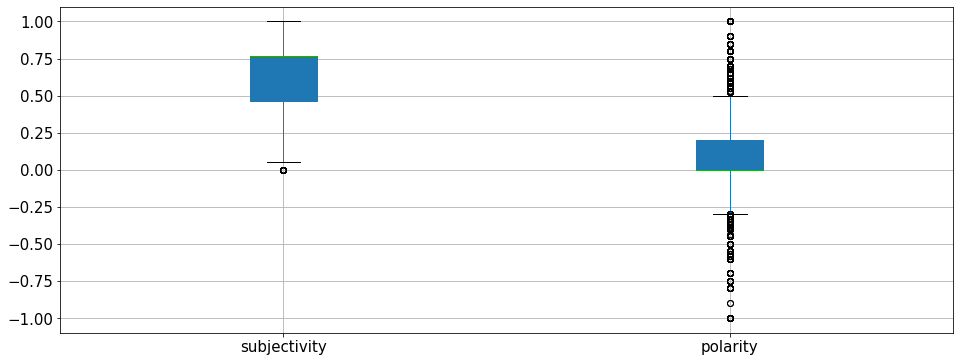

In [22]:
boxplot = dffilter.boxplot(column=['subjectivity','polarity'],patch_artist=True,fontsize = 15,grid = True, vert=True,figsize=(16,6,))

## Scatterplot

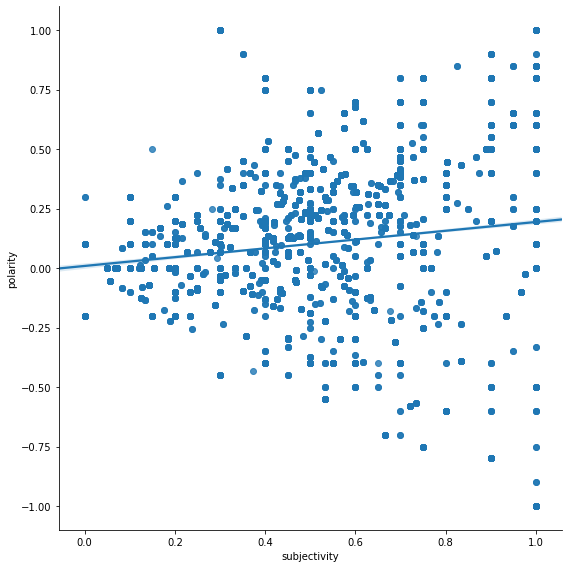

In [23]:
sns.lmplot(x='subjectivity',y='polarity',data=dffilter,fit_reg=True,scatter=True, height=8,palette="mute") 

In [24]:
# calculate the covariance between two variables

# prepare data
data1 = dffilter['subjectivity']
data2 = data1 + dffilter['polarity']
# calculate covariance matrix
covariance = cov(data1, data2) 
print(covariance)

corr, _ = pearsonr(data1, data2)
print('Pearsons correlation: %.5f' % corr)

[[0.0537387  0.06367091]
 [0.06367091 0.15811374]]
Pearsons correlation: 0.69074


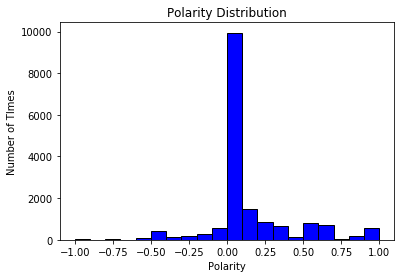

In [25]:
#Polarity Distribution for dffilter

plt.hist(dffilter['polarity'], color = 'b', edgecolor = 'black', density=False,
         bins = int(20))
plt.title('Polarity Distribution')
plt.xlabel("Polarity")
plt.ylabel("Number of TImes")

from pylab import rcParams
rcParams['figure.figsize'] = 16,4

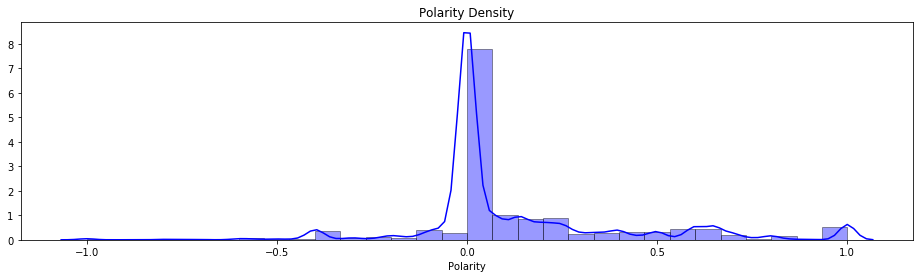

In [26]:
sns.distplot(dffilter['polarity'], hist=True, kde=True, 
             bins=int(30), color = 'b',
             hist_kws={'edgecolor':'black'},axlabel ='Polarity')
plt.title('Polarity Density')

from pylab import rcParams
rcParams['figure.figsize'] = 16,4

# Frequent Words

In [27]:
#Importing stopwords
stopwords = nltk.corpus.stopwords.words('english')

In [28]:
RE_stopwords = r'\b(?:{})\b'.format('|'.join(stopwords))
words = (df.clean_text.str.lower().replace([r'\|',r'\&',r'\-',r'\.',r'\,',r'\'', 
                                      RE_stopwords], [' ', '','','','','',''], regex=True).str.cat(sep=' ').split()
)

In [29]:
# generate DF out of Counter
rslt = pd.DataFrame(Counter(words).most_common(12),
                    columns=['Word', 'Frequency']).set_index('Word')
rslt

,Frequency
Word,
…,12785
player,8883
match,8838
game,8605
duane,8364
vermeulen,8356
final,7506
world,7499
cup,7456


## Wordcloud

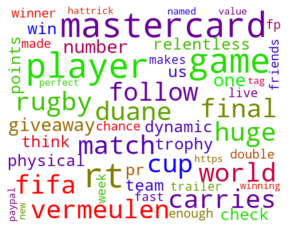

<Figure size 1152x1152 with 0 Axes>

In [33]:
rslt_wordcloud = pd.DataFrame(Counter(words).most_common(100),
                    columns=['Word', 'Frequency'])

wordcloud = WordCloud(max_font_size=60, max_words=50, width=480, height=380,colormap="brg",
                      background_color="white").generate(' '.join(rslt_wordcloud['Word']))
                      
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.figure(figsize=[16,16])
plt.show()

# Getting longitude-latitude coordinates for a list of cities

In [40]:
col2 = ['polarity', 'subjectivity', 'place']
place_sent = pd.DataFrame(columns=col2)

In [49]:
place_sent = [twitter_csv_data['polarity'], twitter_csv_data['subjectivity'], twitter_csv_data['place']]
place_sent = pd.DataFrame(place_sent).T
place_sent[:5]

,polarity,subjectivity,place
0,0.0,0.0,NaN
1,1.0,1.0,"chittagong ,bangladesh"
2,0.65,0.575,NaN
3,1.850371707708594e-17,0.7666666666666666,NaN
4,0.0,0.15476190476190477,South Africa


In [51]:
place_sent_mod = place_sent.dropna()
place_sent_mod[:5]

,polarity,subjectivity,place
1,1.0,1.0,"chittagong ,bangladesh"
4,0.0,0.15476190476190477,South Africa
5,1.850371707708594e-17,0.7666666666666666,東京の下の方
6,1.850371707708594e-17,0.7666666666666666,Saitama
7,0.13636363636363635,0.5,"San Francisco, CA"


In [ ]:
#Some place are in different languages, so this one needs to be translate
list_transl = []   # create empty lists

place_data = pd.DataFrame(place_sent_mod['place'])

for index, row in place_data.iterrows(): # iterate over rows in dataframe
    query = str(row)
    results = mtranslate.translate(query, "en","auto")
    list_transl.append(results)

In [ ]:
#Transform places in coordinates (X,Y)
#OpenCageGeocode key
# @hidden_cell
key = '524066718c7c42609877106eae01295f' 
geocoder = OpenCageGeocode(key)

In [ ]:
list_lat = []   # create empty lists
list_long = []

for index, row in list_transl.iterrows(): # iterate over rows in dataframe
    query = str(row)
    results = geocoder.geocode(query)   
    lat = results[0]['geometry']['lat']
    long = results[0]['geometry']['lng']

    list_lat.append(lat)
    list_long.append(long)

# create new columns from lists    

list_transl['lat'] = list_lat   
list_transl['lon'] = list_long